<a href="https://colab.research.google.com/github/Alimv81/emotion_detection_FER2012/blob/main/emotion_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import albumentations as alb
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
gpu = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpu[0], True)

In [3]:
url = "https://huggingface.co/spaces/mxz/emtion/resolve/c697775e0adc35a9cec32bd4d3484b5f5a263748/fer2013.csv"
df = pd.read_csv(url)

In [4]:
df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [5]:
df['Usage'].value_counts()

Training       28709
PublicTest      3589
PrivateTest     3589
Name: Usage, dtype: int64

In [6]:
df_train = df[df['Usage']=='Training'].copy()
df_test = df[df['Usage']=='PublicTest'].copy()
df_valid = df[df['Usage']=='PrivateTest'].copy()

In [7]:
def split_data(data):
  data['pixels'] = data['pixels'].apply(lambda pixel_sequence: [int(pixel) for pixel in pixel_sequence.split()])
  images = np.array(data['pixels'].tolist(), dtype='float32').reshape(-1, 48, 48, 1) / 255.0
  images = np.repeat(images, 3, axis=-1)
  labels = data['emotion'].to_numpy()

  return images, labels

In [8]:
train_data, train_labels = split_data(df_train)
test_data, test_labels = split_data(df_test)
validation_data, validation_labels = split_data(df_valid)

In [32]:
from tensorflow.keras.layers import Dense, BatchNormalization, Activation, Conv2D, MaxPooling2D, Flatten, Dropout

model = tf.keras.Sequential()

In [33]:
model.add(Conv2D(128, kernel_size=(3, 3), input_shape=(48, 48, 3), data_format='channels_last'))
model.add(Activation('relu'))
model.add(Conv2D(256, kernel_size=(3, 3), padding='same'))
model.add(Dropout(.5))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(Conv2D(256, kernel_size=(3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(Flatten())
model.add(Dense(1024))
model.add(Dropout(.5))
model.add(Activation('relu'))

model.add(Dense(128))
model.add(Dropout(.5))
model.add(Activation('relu'))

model.add(Dense(7, activation='softmax'))

In [34]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy

model.compile(loss=SparseCategoricalCrossentropy(),
              optimizer=Adam())

In [35]:
model.fit(train_data, train_labels, epochs=12, validation_data=(validation_data, validation_labels))

Epoch 1/12
898/898 [==============================] - 42s 44ms/step - loss: 1.7749 - val_loss: 1.6776
Epoch 2/12
898/898 [==============================] - 39s 43ms/step - loss: 1.5290 - val_loss: 1.4351
Epoch 3/12
898/898 [==============================] - 39s 44ms/step - loss: 1.3729 - val_loss: 1.3287
Epoch 4/12
898/898 [==============================] - 39s 43ms/step - loss: 1.2673 - val_loss: 1.2880
Epoch 5/12
898/898 [==============================] - 39s 43ms/step - loss: 1.1608 - val_loss: 1.2426
Epoch 6/12
898/898 [==============================] - 39s 43ms/step - loss: 1.0496 - val_loss: 1.2268
Epoch 7/12
898/898 [==============================] - 39s 43ms/step - loss: 0.9398 - val_loss: 1.1808
Epoch 8/12
898/898 [==============================] - 39s 43ms/step - loss: 0.8242 - val_loss: 1.2085
Epoch 9/12
898/898 [==============================] - 39s 43ms/step - loss: 0.7138 - val_loss: 1.2075
Epoch 10/12
898/898 [==============================] - 39s 43ms/step - loss: 0.623

In [36]:
emotion_map = {0: 'Angry', 1: 'Digust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

In [37]:
predy = model.predict(test_data)

113/113 [==============================] - 1s 9ms/step


In [38]:
predy[0], np.argmax(predy[0])

(array([0.21880125, 0.02117541, 0.17431974, 0.00045718, 0.12306933,
        0.01733472, 0.44484228], dtype=float32),
 6)

In [39]:
from sklearn.metrics import accuracy_score

print(accuracy_score(test_labels, np.argmax(predy, axis=1)))

0.5583728057954862


In [61]:
idx = [12, 456, 1568, 3194]
image_batch = test_data[idx]
label_batch = test_labels[idx]
label_batch_pred = np.argmax(predy[idx], axis=1)

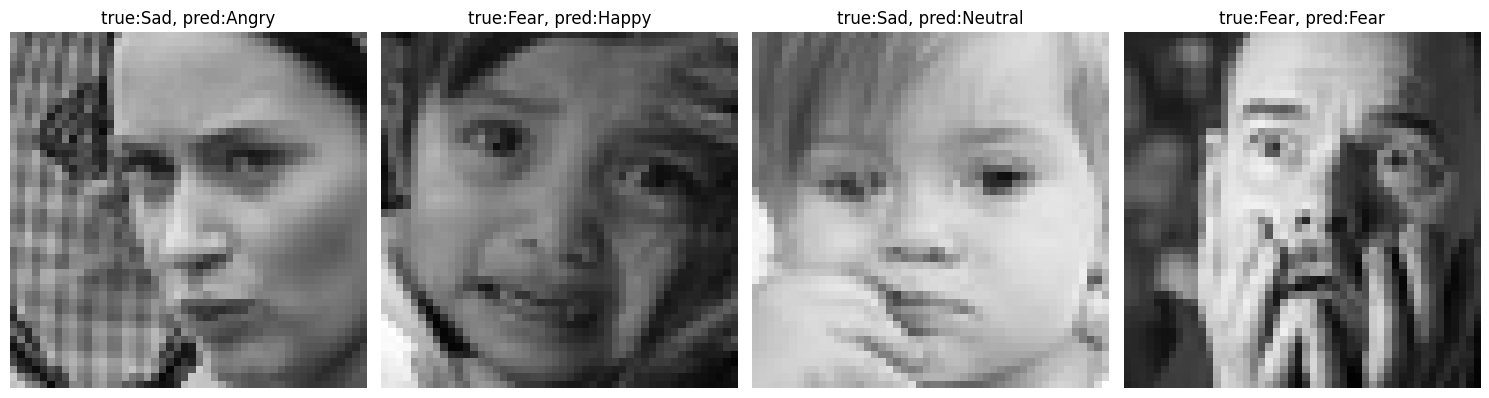

In [62]:
fig, axes = plt.subplots(1, 4, figsize=(15, 5))

for i, ax in enumerate(axes):
    image = image_batch[i]
    ax.imshow(image)
    ax.set_title(f'true:{emotion_map[label_batch[i]]}, pred:{emotion_map[label_batch_pred[i]]}')
    ax.axis('off')

plt.tight_layout()
plt.show()